Kaggle link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### 1. Importing packages

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### 2. Loading datasets and Feature engineering

In [ ]:
# reading train data + exam data, then combining them for preprocessing
XY_all = pd.read_csv('train.csv', index_col=0)

Y_all = np.log(XY_all['SalePrice'])
X_all = XY_all.drop('SalePrice', axis=1)
X_exam = pd.read_csv('test.csv', index_col=0)

X_combined0 = pd.concat([X_all, X_exam], axis=0)
print (X_combined0.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [ ]:
# removing columns with missing values more than 20%
X_null = X_combined0.isnull().sum(axis=0)
max_na = X_combined0.shape[0] * 0.2
col = [c for c in X_combined0.columns if X_null[c] <= max_na]
X_combined1 = X_combined0[col]
print (X_combined1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

In [ ]:
# some string columns are categorical, but some are ordinal
num_cols = X_combined1.select_dtypes(include=np.number).columns.tolist()
str_cols = X_combined1.select_dtypes(include='object').columns.tolist()
grade_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
            'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
cat_cols = str_cols.copy()
ord_cols = []
for c in grade_cols:
    if c in cat_cols:
        cat_cols.remove(c)
        ord_cols.append(c)
        
print ("Cardinal columns = ", len(num_cols))
print ("Categorical columns = ", len(cat_cols))
print ("Ordinal columns = ", ord_cols)

Cardinal columns =  36
Categorical columns =  30
Ordinal columns =  ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']


In [ ]:
# imputation of cardinal (numeric) columns and categorical columns
from sklearn.impute import SimpleImputer

# imputation of cardinal (numeric) columns
num_imputer = SimpleImputer(strategy='mean')
X_combined2 = X_combined1.copy()
X_combined2[num_cols] = num_imputer.fit_transform(X_combined1[num_cols])

# imputation of categorical columns
str_imputer = SimpleImputer(strategy='most_frequent')
X_combined2[cat_cols] = str_imputer.fit_transform(X_combined1[cat_cols])

# adding an interaction column
X_combined2['GrLivArea * OverallQual'] = X_combined2['GrLivArea'] * X_combined2['OverallQual']
print (X_combined2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 75 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MSSubClass               2919 non-null   float64
 1   MSZoning                 2919 non-null   object 
 2   LotFrontage              2919 non-null   float64
 3   LotArea                  2919 non-null   float64
 4   Street                   2919 non-null   object 
 5   LotShape                 2919 non-null   object 
 6   LandContour              2919 non-null   object 
 7   Utilities                2919 non-null   object 
 8   LotConfig                2919 non-null   object 
 9   LandSlope                2919 non-null   object 
 10  Neighborhood             2919 non-null   object 
 11  Condition1               2919 non-null   object 
 12  Condition2               2919 non-null   object 
 13  BldgType                 2919 non-null   object 
 14  HouseStyle              

In [ ]:
# imputation of ordinal columns
ord2int_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:np.nan}

for col in ord_cols:
    X_combined2[col] = X_combined2[col].map(ord2int_map)

ord_imputer = SimpleImputer(strategy='mean')
X_combined3 = X_combined2.copy()
X_combined3[ord_cols] = ord_imputer.fit_transform(X_combined2[ord_cols])

X_combined3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 75 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MSSubClass               2919 non-null   float64
 1   MSZoning                 2919 non-null   object 
 2   LotFrontage              2919 non-null   float64
 3   LotArea                  2919 non-null   float64
 4   Street                   2919 non-null   object 
 5   LotShape                 2919 non-null   object 
 6   LandContour              2919 non-null   object 
 7   Utilities                2919 non-null   object 
 8   LotConfig                2919 non-null   object 
 9   LandSlope                2919 non-null   object 
 10  Neighborhood             2919 non-null   object 
 11  Condition1               2919 non-null   object 
 12  Condition2               2919 non-null   object 
 13  BldgType                 2919 non-null   object 
 14  HouseStyle              

### 3. Ridge regression

In [ ]:
# extracting exam data from pre-processed combined data
def split_train_exam(X_combined, n):
    X_task = X_combined.iloc[:n,:]
    X_exam = X_combined.iloc[n:,:]
    return X_task, X_exam

# computing R^2 & RMSE and printing them
def model_perf(model, X, Y, prefix=''):
    Yhat = model.predict(X)
    r2 = r2_score(Y, Yhat)
    rmse = mean_squared_error(Y, Yhat, squared=False)
    print (f'{prefix} R^2 score = {r2:.3f}, RMSE = {rmse:.4f}')

def model_fit_perf(model, X_all, Y_all, prefix=''):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=0)
    model.fit(X_trn, Y_trn)
    print (prefix)
    model_perf(model, X_trn, Y_trn, '  Training  ')
    model_perf(model, X_val, Y_val, '  Validation')
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    s = cross_val_score(model, X_all, Y_all, cv=kfold)
    print (f'  Cross val. R^2 score mean = {s.mean():.3f}, std = {s.std():.3f}')

In [ ]:
# converting categorical var. to dummy var.
X_combined4 = pd.get_dummies(X_combined3)

# extracting exam data from pre-processed combined data
X_task1, X_exam1 = split_train_exam(X_combined4, X_all.shape[0])

# ridge regression
# model_fit_perf : fit, training performance, val. performance, cross val. performance  
ridge = Ridge()
model_fit_perf(ridge, X_task1, Y_all, "Ridge")

Ridge
  Training   R^2 score = 0.946, RMSE = 0.0936
  Validation R^2 score = 0.767, RMSE = 0.1876
  Cross val. R^2 score mean = 0.868, std = 0.053


### 4. Advanced tree based models

In [ ]:
# advanced tree based models
bagging = BaggingRegressor(n_estimators=50)
model_fit_perf(bagging, X_task1, Y_all, "Bagging")

random_forest = RandomForestRegressor(n_estimators=50)
model_fit_perf(random_forest, X_task1, Y_all, "Random Forest")

xgb = XGBRegressor(max_depth=5, objective="reg:squarederror")
model_fit_perf(xgb, X_task1, Y_all, "XGBoost")

lgbm = LGBMRegressor()
model_fit_perf(lgbm, X_task1, Y_all, "LightGBM")

Bagging
  Training   R^2 score = 0.982, RMSE = 0.0546
  Validation R^2 score = 0.872, RMSE = 0.1391
  Cross val. R^2 score mean = 0.874, std = 0.016
Random Forest
  Training   R^2 score = 0.983, RMSE = 0.0530
  Validation R^2 score = 0.874, RMSE = 0.1383
  Cross val. R^2 score mean = 0.873, std = 0.018
XGBoost
  Training   R^2 score = 0.982, RMSE = 0.0541
  Validation R^2 score = 0.881, RMSE = 0.1341
  Cross val. R^2 score mean = 0.898, std = 0.015
LightGBM
  Training   R^2 score = 0.988, RMSE = 0.0442
  Validation R^2 score = 0.876, RMSE = 0.1371
  Cross val. R^2 score mean = 0.890, std = 0.020


In [ ]:
# heterogeneous ensembles
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

estms = [('r', ridge), ('b', bagging), ('rf', random_forest), 
        ('xgb', xgb), ('lgbm', lgbm)]

voting = VotingRegressor(estimators=estms)
model_fit_perf(voting, X_task1, Y_all, "Voting(mean) Ensemble")

stacking = StackingRegressor(estimators=estms, final_estimator=Ridge())
model_fit_perf(stacking, X_task1, Y_all, "Stacking Ensemble")

Voting(mean) Ensemble
  Training   R^2 score = 0.983, RMSE = 0.0521
  Validation R^2 score = 0.881, RMSE = 0.1344
  Cross val. R^2 score mean = 0.900, std = 0.020
Stacking Ensemble
  Training   R^2 score = 0.976, RMSE = 0.0619
  Validation R^2 score = 0.866, RMSE = 0.1425
  Cross val. R^2 score mean = 0.903, std = 0.024


### 5. Results

In [ ]:
sale_price_pred = np.exp(voting.predict(X_exam1))

submission_df = pd.read_csv('sample_submission.csv', index_col=0)
submission_df['SalePrice'] = sale_price_pred

submission_df.to_csv('mysub.csv')

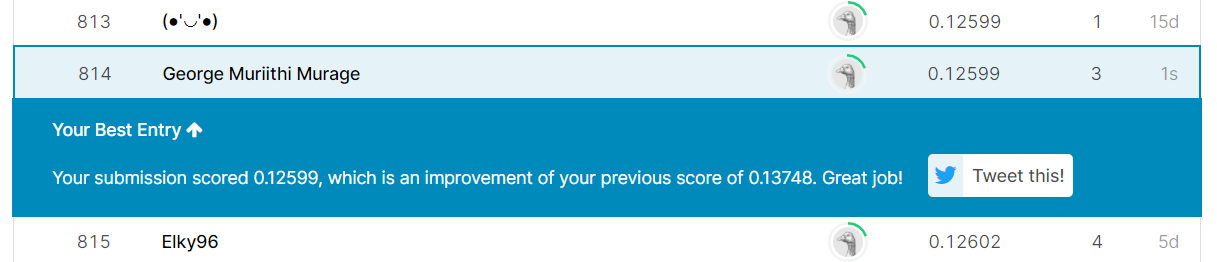